In [18]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from diffusers import StableDiffusionInpaintPipeline
import numpy as np
from PIL import Image
import requests
import torch


In [20]:
clipseg_processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

pipe = StableDiffusionInpaintPipeline.from_single_file(
    "../models/sd-v1-5-inpainting.ckpt"
)

pipe.safety_checker  = None

def gen_mask(image, target_text, threshold=0.5):
    inputs = clipseg_processor(text=target_text, images=[image], padding=True, return_tensors="pt")
    outputs = clipseg_model(**inputs)
    logits = outputs.logits

    tensor_min = logits.min()
    tensor_max = logits.max()
    normalized_tensor = (logits - tensor_min) / (tensor_max - tensor_min)

    # Apply thresholding
    thresholded_tensor = (normalized_tensor > threshold).float() * normalized_tensor * 255
    numpy_image = thresholded_tensor.detach().numpy()

    # Convert to an 8-bit grayscale image
    numpy_image_8bit = numpy_image.astype(np.uint8)
    mask = Image.fromarray(numpy_image_8bit, mode='L')
    
    return mask

def apply_workflow(image, prompt):
    mask_image = gen_mask(image, "fruit", threshold=0.5)
    gen_image = pipe(prompt=prompt, image=image, mask_image=mask_image, num_inference_steps=10).images[0]
    return mask_image, gen_image

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/home/ruben/miniconda3/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [23]:
from PIL import Image

image = Image.open("test.jpg")

In [30]:
prompt = "A hand holding a handful of candies"

image_gen, image_mask = apply_workflow(image, prompt)

100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


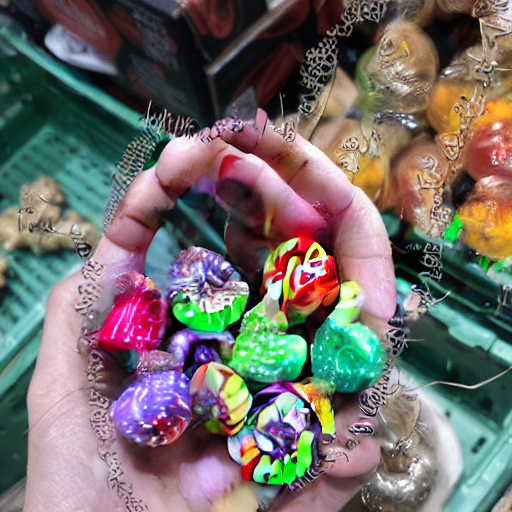

In [31]:
image_mask

100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


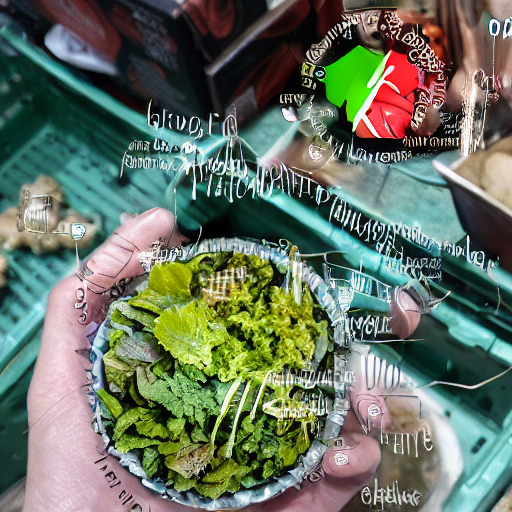

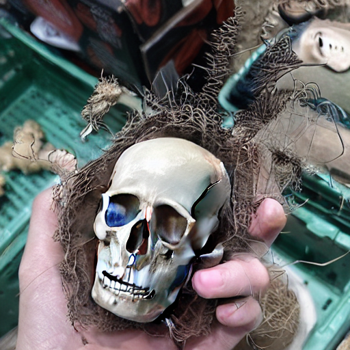

In [8]:
gen_image.resize((350, 350))

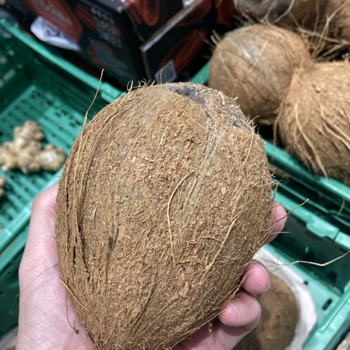

In [70]:
image.resize((350, 350))